# hj_reachability quickstart

Notebook dependencies:
- System: python3, ffmpeg (for rendering animations)
- Python: jupyter, jax, numpy, matplotlib, plotly, tqdm, hj_reachability

Example setup for a Ubuntu system (Mac users, maybe `brew` instead of `sudo apt`; Windows users, learn to love [WSL](https://docs.microsoft.com/en-us/windows/wsl/install-win10)):
```
sudo apt install ffmpeg
/usr/bin/python3 -m pip install --upgrade pip
pip install --upgrade jupyter jax[cpu] numpy matplotlib plotly tqdm hj-reachability
jupyter notebook  # from the directory of this notebook
```
Alternatively, view this notebook on [Google Colab](https://colab.research.google.com/github/StanfordASL/hj_reachability/blob/main/examples/quickstart.ipynb) and run a cell containing this command:
```
!pip install --upgrade hj-reachability
```

In [2]:
!pip install --upgrade hj-reachability

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 180 kB 14.8 MB/s 
     |████████████████████████████████| 217 kB 70.8 MB/s 
     |████████████████████████████████| 145 kB 69.0 MB/s 
     |████████████████████████████████| 51 kB 7.5 MB/s 
     |████████████████████████████████| 85 kB 4.3 MB/s 


In [3]:
import jax
import jax.numpy as jnp
import numpy as np

from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objects as go

import hj_reachability as hj

Will's Trial Koopman System

In [ ]:
# class Test(hj.ControlAndDisturbanceAffineDynamics):

#     def __init__(self,
#                  control_mode="min",
#                  disturbance_mode="max",
#                  control_space=None,
#                  disturbance_space=None):
      
#         if control_space is None:
#             control_space = hj.sets.Ball(jnp.zeros(2), 0)

#         if disturbance_space is None:
#             disturbance_space = hj.sets.Ball(jnp.zeros(2), 0)

#         super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

#     def open_loop_dynamics(self, state, time):
#         _, _, v, q = state
#         return jnp.array([v * jnp.cos(q), v * jnp.sin(q), 0., 0.])

#     def control_jacobian(self, state, time):
#         return jnp.array([
#             [0.,  1.],
#             [0.1, 0.],
#         ])

#     def disturbance_jacobian(self, state, time):
#         return jnp.array([
#             [0.,  1.],
#             [0.1, 0.],
#         ])

In [18]:
class TestLifted(hj.ControlAndDisturbanceAffineDynamics):

    def __init__(self,
                 mu=-0.05, 
                 lam=-1.,
                 r=0., #autonomous by default
                 control_mode="min",
                 disturbance_mode="max",
                 control_space=None,
                 disturbance_space=None):

        self.mu = mu
        self.lam = lam
        self.r = r

        if control_space is None:
            control_space = hj.sets.Ball(jnp.zeros(2), self.r)

        if disturbance_space is None:
            disturbance_space = hj.sets.Ball(jnp.zeros(2), 0.5 * self.r)

        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    def open_loop_dynamics(self, state, time):
        x2, z = state
        return jnp.array([self.lam * (x2 - z), 
                          2 * self.mu * z])

    def control_jacobian(self, state, time):
        B = jnp.array([[0.,  1.],
                       [2 * self.mu, 0.]])
        return B

    def disturbance_jacobian(self, state, time):
        C = jnp.array([[0.,  1.],
                       [2 * self.mu, 0.]])
        return C

## Textbook Koopman System (Autonomous)

In [8]:
## Solve Final Time

dynamics = TestLifted(r=0)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo=np.array([2., 2.]),
                                                                           hi=np.array([8., 8.])),
                                                               (61, 61),
                                                               periodic_dims=2) ## ?
                                              

# values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 1 
initial_values = (0.5 * jnp.sum(jnp.square(grid.states - jnp.array([5, 5])), axis=2)) - 0.5

solver_settings = hj.SolverSettings.with_accuracy("very_high") ## What about BRS setting

time = 0.
# target_time = -1.0
target_time = -1.

## Single_time
target_values = hj.step(solver_settings, dynamics, grid, time, initial_values, target_time)

/usr/local/lib/python3.7/dist-packages/hj_reachability/utils.py:54: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  axis_sequence_structure = jax.tree_structure(next(a for a in jax.tree_leaves(in_axes) if a is not None).tolist())
/usr/local/lib/python3.7/dist-packages/hj_reachability/utils.py:54: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  axis_sequence_structure = jax.tree_structure(next(a for a in jax.tree_leaves(in_axes) if a is not None).tolist())
/usr/local/lib/python3.7/dist-packages/hj_reachability/utils.py:55: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  vmap_kwargs = jax.tree_transpose(jax.tree_structure(multivmap_kwargs), axis_sequence_structure,
/usr/local/lib/python3.7/dist-packages/hj_reachability/utils.py:56: FutureWa

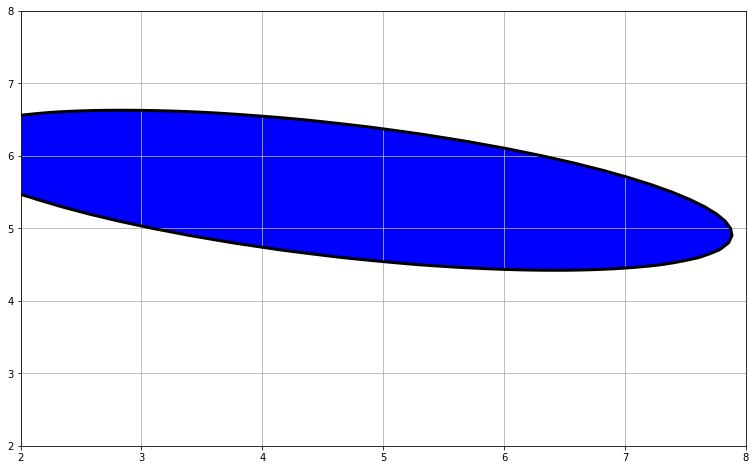

In [9]:
## Plot

plt.figure(figsize=(13, 8))
plt.grid(True)
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values.T, levels=0, colors = ["blue", "white"]);
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values.T,
            # initial_values,
            levels=0,
            colors="black",
            linewidths=3);

In [10]:
## Solve Up to Final Time

times = np.linspace(0, target_time, 50)
all_values = hj.solve(solver_settings, dynamics, grid, times, initial_values)

100%|##########|  1.0000/1.0 [00:00<00:00,  8.17sim_s/s]


In [11]:
## Animate

cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["red","purple","blue"])
vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin)-1, round(vmax), round(vmax) - round(vmin) + 2)

fig = plt.figure(figsize=(13, 8))
def render_frame(i):
    plt.grid(True)
    plt.contourf(grid.coordinate_vectors[0],
                 grid.coordinate_vectors[1],
                 all_values[i, :, :].T,
                 colors=[cmap(i/50), "white"],
                 levels=0)
    plt.contour(grid.coordinate_vectors[0],
                grid.coordinate_vectors[1],
                initial_values,
                levels=0,
                colors="black",
                linewidths=3)


render_frame(0)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


## Textbook Koopman System (Control radius = 2 * Disturbance radius)

100%|##########|  1.0000/1.0 [00:00<00:00, 13.91sim_s/s]
100%|##########|  1.0000/1.0 [00:00<00:00, 10.67sim_s/s]
100%|##########|  1.0000/1.0 [00:00<00:00,  5.57sim_s/s]
100%|##########|  1.0000/1.0 [00:00<00:00,  4.00sim_s/s]


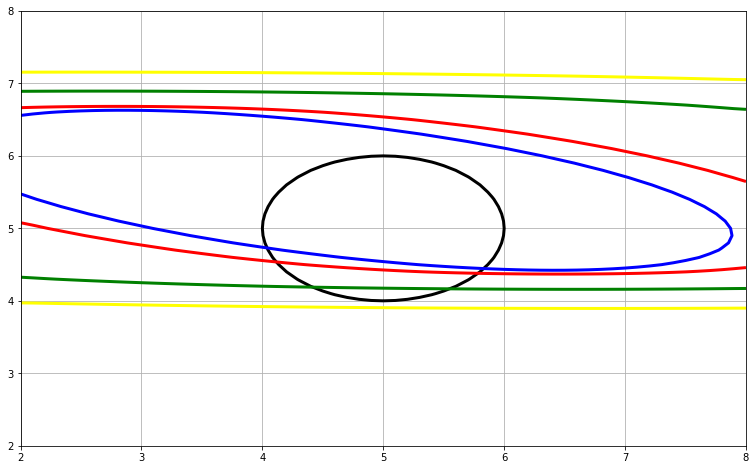

In [25]:
## Iterate through Control/Disturbance Set size

plt.figure(figsize=(13, 8))
plt.grid(True)

initial_values = (0.5 * jnp.sum(jnp.square(grid.states - jnp.array([5, 5])), axis=2)) - 0.5
solver_settings = hj.SolverSettings.with_accuracy("very_high")

plt.contour(grid.coordinate_vectors[0],
                grid.coordinate_vectors[1],
                initial_values,
                levels=0,
                colors="black",
                linewidths=3)

for ri, r in enumerate([0., 1., 5., 10.]):

    ## Solve Final Time
    dynamics = TestLifted(r=r)
    grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo=np.array([2., 2.]),
                                                                              hi=np.array([8., 8.])),
                                                                  (61, 61),
                                                                  periodic_dims=2) ## ?
                        
    time = 0.
    target_time = -1.

    ## Single_time
    target_values = hj.step(solver_settings, dynamics, grid, time, initial_values, target_time)

    ## Plot
    # plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values.T, levels=0, colors = [["blue", "red", "green", "yellow"][ri], "white"], alpha = 0.4);
    plt.contour(grid.coordinate_vectors[0],
                grid.coordinate_vectors[1],
                target_values.T,
                levels=0,
                colors=["blue", "red", "green", "yellow"][ri],
                linewidths=3);

# plt.legend(["r = " + str(i) for i in [0., 1., 5., 10.]])

['r = 0.0', 'r = 1.0', 'r = 5.0', 'r = 10.0']